# 2. Data Collection - Part 2

In this notebook, I will label the downloaded data by tagging P&L statements from the reports through a combination of RegEx parsing and visual inspection. 

## Table of Contents

1. [Read the files](#Read-the-files)
1. [Define RegEx Pattern](#Define-RegEx-Pattern)
1. [Build a DataFrame](#Build-a-DataFrame)
1. [Clean the data](#Clean-the-data)
1. [Save to file](#Save-to-file)

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from glob import glob
import re
from ipywidgets import interact
import ipywidgets as widgets

## Read the files

In [2]:
def read_file(folder, name):
    '''Reads a file given a folder and file name.'''
    
    with open('files/' + folder + '/' + name, 'r') as file:
        contents = file.read()
        
    return contents    
    
def read_html_report(folder):
    '''Reads a report in HTML format.'''
    
    return read_file(folder, '10k.html')

def read_text_report(folder):
    '''Reads a report in text format.'''
    
    return read_file(folder, '10k.txt')

def read_clean_report(folder):
    '''Reads a cleaned report in text format.'''
    
    return read_file(folder, '10k_clean.txt')

def read_filing_file(folder):
    '''Reads a file with filing details.'''
    
    return read_file(folder, 'filing.txt')

In [3]:
# get a full list of companies
company_list = [x.replace('files/', '').replace('/', '') for x in glob('files/*/')]
company_list.sort()

In [4]:
def clean_files():
    '''Cleans redundant whitespace from reports.'''
    
    for company in company_list:
        raw_text = read_text_report(company)
        clean_text = re.sub('(?<=\n)[\xa0\t ]+', '', raw_text)
        clean_text = re.sub('\n{2,}', '\n', clean_text)
        with open('files/'+company+'/'+'10k_clean.txt', 'w') as file:
            file.write(clean_text)

## Define Pattern

In [5]:
def parse_pnl(name):
    '''Parses a P&L from the cleaned up report.'''
    
    r = read_clean_report(name)
    pattern = get_pattern()    
    return re.search(pattern, r, flags=re.I).group()

def print_pnl(name, method='print'):
    '''Prints or displays a P&L, depending on the method.'''
    
    try:
        parsed_pnl = parse_pnl(name)
        print('Parsed PnL:')
        exec('{}({})'.format(method, 'parsed_pnl'))
    except AttributeError:
        report = read_clean_report(name)
        exec('{}({})'.format(method, 'report'))
    
def print_checks(name):
    '''Prints the spot check verifications.'''
    
    try:
        pnl = parse_pnl(name).split('\n')
        prev_page = pnl[0].split()[0]
        curr_page = pnl[-1].split()[-1].split('-')[-1]
        check = (int(curr_page)-int(prev_page)==1)
        print('Page numbers tie: {}\t\tPrevious page: {}\tCurrent page: {}'.format(check, prev_page, curr_page))
    
    except AttributeError:
        print('Pattern hasn\'t been found')

In [6]:
def add_whitespace(string):
    '''Adds extra whitespace to the RegEx'''
    
    return '\s+'.join(string.split())
    
def options_to_regex(options):
    '''Helper function that builds RegEx string from a list of options.'''
    
    options_str = '|'.join(options)
    options_with_whitespace = add_whitespace(options_str)
    
    return r'(?:{})'.format(options_with_whitespace)

In [7]:
def get_pattern():
    '''Defines a pattern used for P&L parsing.'''
    
    exclude_list =['(?:Consolidated )?balance sheets', 
                           '(?:Consolidated )Statements of Cash Flows',
                           'Consolidated statements of stockholders'
                          'Total liabilities and stockholders']
    title_options = [r'(?:Consolidated )?Statements of (?:Income|Operations)']
    footnote_options = [r'See (?:accompanying )?notes to (?:the )?(?:consolidated )?financial statements?.?',
                        r'The accompanying notes are an integral part of th(?:ese|is) (?:consolidated )?financial statements?.?']
    header_options = [r'Years? ended']
    
    title = options_to_regex(title_options)
    exclude = r'(?!{})'.format(options_to_regex(exclude_list))
    header = options_to_regex(header_options)
    footnote = options_to_regex(footnote_options)
    
    page_number = r'(?:(?<=\n)|(?<=\n- |\n[A-Z]-))\d{1,2}(?:(?=\n)|(?= -\n))'
    padding3 = r'(?:(?:{}.)*\n+){{,3}}.*'.format(exclude)
    padding5 = r'(?:(?:{}.)*\n+){{,5}}.*'.format(exclude)
    anything = r'(?:{}[\s\S]){{200,4000}}?'.format(exclude)
    
    return page_number + padding5 + title + padding5 + header + anything + footnote + padding3 + page_number

In [8]:
def pnl_viewer(company_list, company):
    '''Displays a P&L viewer to observe the parsing results.'''
    
    name = widgets.Dropdown(
        options=company_list,
        value=company,
        description='Company:')
    method = widgets.Dropdown(
        options=['print', 'display'],
        value='print',
        description='Method:')

    out_check = widgets.interactive_output(print_checks, {'name': name})
    out_pnl = widgets.interactive_output(print_pnl, {'name': name, 'method': method})

    display(widgets.HBox([name, method]))
    display(out_check)
    display(out_pnl)

In [9]:
# display the results of the parsing
try:
    company = name.value 
except NameError:
    company = company_list[0]

try:
    companies = unlabeled_reports.dir 
except NameError:
    companies = company_list
    
pnl_viewer(company_list, company)

Output()

Output()

## Build DataFrame

In [10]:
def build_df(company_list):
    '''Builds a DataFrame from a company list.'''
    
    reports = []
    for company in company_list:
        report = read_clean_report(company)
        reports.append([company, report])

    return pd.DataFrame(columns=['dir', 'report'], data = reports)

In [11]:
# build a DataFrame from a list of companies
df_raw = build_df(company_list)
df = df_raw.copy()

In [12]:
is_labeled = df.report.str.contains(get_pattern(),flags=re.I)

In [13]:
unlabeled_reports = df[~is_labeled]

In [14]:
unlab = unlabeled_reports.shape[0]
lab = len(df) - unlab
print('Labeled: {}\nUnlabeled: {}'.format(lab, unlab))

Labeled: 604
Unlabeled: 497


In [15]:
df['pnl']=df.report.str.findall(get_pattern(),flags=re.I)

## Clean the data

In [16]:
def print_for_visual_check(df, top_n_chars=None):
    
    for _, data in df.iterrows():
        print('-'*100)
        print(data.dir)
        print('-'*100)
        if top_n_chars:
            print(data.pnl[:top_n_chars])
        else:
            print(data.pnl)

### Check the number of matches per report

In [17]:
df['finds_count'] = df.pnl.apply(lambda x: len(x))

In [18]:
df.finds_count.value_counts()

1    596
0    497
3      8
Name: finds_count, dtype: int64

In [19]:
df[df.finds_count>1]

,dir,report,pnl,finds_count
387,Frontier Balanced Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
388,Frontier Diversified Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
389,Frontier Funds,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
390,Frontier Global Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
391,Frontier Heritage Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
392,Frontier Long_Short Commodity Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
393,Frontier Masters Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3
394,Frontier Select Fund,\n10-K\n1\ns117344_10k.htm\nFORM 10-K\nUNITED\...,[13\nThe Series of Frontier Funds\nStatements ...,3


In [20]:
df.pnl = df.pnl.apply(lambda x: x[0] if len(x)==1 else np.NaN)

### Visually check the headers of all matches

In [21]:
not_empty = df.pnl.notna()

In [22]:
not_empty.sum()

596

In [23]:
print_for_visual_check(df[not_empty], 300)

----------------------------------------------------------------------------------------------------
12 Retech Corp
----------------------------------------------------------------------------------------------------
3
12
RETECH CORPORATION
Consolidated
Statements of Operations and Comprehensive Loss
Years
Ended
December
31,
2018
2017
Revenues
$
92,831
$
60,787
Cost of
revenue
50,558
49,586
Gross
Profit
42,273
11,201
Operating
Expenses
General
and administrative
2,146,385
757,688
Professional
fees
1,142,127
596,
----------------------------------------------------------------------------------------------------
1847 Holdings LLC
----------------------------------------------------------------------------------------------------
3
Table of Contents
1847 HOLDINGS LLC
CONSOLIDATED STATEMENTS OF OPERATIONS
Years Ended 
December 31,
2018
2017
REVENUES
Services
$
4,631,507
$
3,987,955
Sales and other
2,702,340
2,422,665
TOTAL REVENUE
7,333,847
6,410,620
OPERATING EXPENSES
Cost of sales
2,370

----------------------------------------------------------------------------------------------------
2
Table of Contents
Youngevity International, Inc. and
Subsidiaries
Consolidated Statements of Operations
(In thousands, except share and per share amounts)
Years Ended December 31,
2018
2017
Revenues
$
162,445
$
165,696
Cost
of revenues
67,413
70,131
Gross
profit
95,032
95,565
Operating
expenses
Di
----------------------------------------------------------------------------------------------------
Yuma Energy, Inc.
----------------------------------------------------------------------------------------------------
4
Yuma Energy, Inc.
CONSOLIDATED
STATEMENTS OF OPERATIONS
Years Ended December 31,
2018
2017
REVENUES:
Sales
of natural gas and crude oil
$
21,471,093
$
25,443,601
EXPENSES:
Lease
operating and production costs
10,561,464
11,037,313
General
and administrative – stock-based compensation
582,344
2,381
-----------------------------------------------------------------------------

### Check the total lenght of the matches

In [24]:
df['len'] = df.pnl.apply(lambda x: len(str(x)) if x else np.NaN)

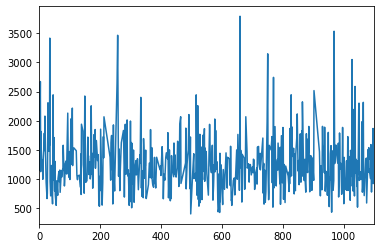

In [25]:
df.len[df.pnl.notna()].plot();

### Visually check the longest matches

In [26]:
is_long = (df.len>3000)

In [27]:
is_long.sum()

6

In [28]:
companies = df[is_long].dir
pnl_viewer(companies, companies.tolist()[0])

Output()

Output()

### Visually check the shortest matches

In [29]:
is_short = (df.pnl.notna()&(df.len<500))

In [30]:
is_short.sum()

5

In [31]:
companies = df[is_short].dir
pnl_viewer(companies, companies.tolist()[0])

Output()

Output()

### Check page number match

In [32]:
df['prev_page'] = df.pnl.apply(lambda x: str(x).split()[0] if x else np.NaN)
df['curr_page'] = df.pnl.apply(lambda x: str(x).split()[-1].split('-')[-1] if x else np.NaN)

In [33]:
pages_do_not_tie = (df.pnl.notna()&(df.curr_page.astype(float)-df.prev_page.astype(float)!=1))

In [34]:
pages_do_not_tie.sum()

15

In [35]:
df[pages_do_not_tie]

,dir,report,pnl,finds_count,len,prev_page,curr_page
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...,1,1152,3,12
3,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...,1,2671,2,4
108,Atlantic Alliance Partnership Corp.,\n10-K\n1\nf10k2018_atlanticalliance.htm\nANNU...,3\nATLANTIC ALLIANCE PARTNERSHIP CORP.\nStatem...,1,2216,3,6
121,"BIOHITECH GLOBAL, INC.",\n10-K\n1\ntv516352_10k.htm\nFORM 10-K\nUNITED...,5\nReport of Independent Registered Public Acc...,1,1485,5,1
243,"ChinaNet Online Holdings, Inc.",\n10-K\n1\nf10k_040819p.htm\nFORM 10-K\nUNITED...,"4\nCHINANET ONLINE HOLDINGS, INC.\nCONSOLIDATE...",1,1928,4,6
257,"Contura Energy, Inc.",\n10-K\n1\ncontura12312018financials.htm\n10-K...,"92\nTable of Contents\nCONTURA ENERGY, INC. AN...",1,3464,92,94
369,FREDS INC,\n10-K\n1\nfred-10k_20190202.htm\n10-K\nfred-1...,"52\n-\nFRED’S, INC.\nCONSOLIDATED STATEMENTS O...",1,1539,52,54
515,InsPro Technologies Corp,\n10-K\n1\ntv516518_10k.htm\nFORM 10-K\nUNITED...,3\nINSPRO TECHNOLOGIES CORPORATION AND SUBSIDI...,1,2443,3,5
659,"Millendo Therapeutics, Inc.",\n10-K\n1\nmind-20181231x10k.htm\n10-K\nmlnd_C...,"91\nTable of Contents\nMillendo Therapeutics, ...",1,3790,91,93
742,PACIFIC BLUE ENERGY CORP.,\n10-K\n1\npbec10k-20181231.htm\nPACIFIC BLUE ...,2\n13\nPacific Blue Energy Corp.\nConsolidated...,1,601,2,14


In [36]:
companies = df[pages_do_not_tie].dir
pnl_viewer(companies, companies.tolist()[0])

Output()

Output()

In [37]:
df.at[0, 'pnl'] =  re.sub('\nF-\n4\n12$', '\nF-\n4', df.loc[0, 'pnl'])
df.at[3, 'pnl'] =  re.search('[\s\S]+\nF-3', df.loc[3, 'pnl']).group()
df.at[108, 'pnl'] =  re.search('[\s\S]+\nF-\n4', df.loc[108, 'pnl']).group()
df.at[515, 'pnl'] =  re.search('[\s\S]+\nF-\n4', df.loc[515, 'pnl']).group()
df.at[659, 'pnl'] =  re.search('[\s\S]+\n92(?=\nTable of Contents\nMillendo Therapeutics)', 
                               df.loc[659, 'pnl']).group()
df.at[742, 'pnl'] =  re.search('[\s\S]+\nF-3', df.loc[742, 'pnl']).group()
df.at[860, 'pnl'] =  re.search('45\nSEARS HOMETOWN AND OUTLET STORES, INC.\n[\s\S]+', df.loc[860, 'pnl']).group()
df.at[861, 'pnl'] =  re.search('11\nSector 10, Inc.\n\(A DEVELOPMENT STAGE COMPANY\)[\s\S]+', 
                               df.loc[861, 'pnl']).group()
df.at[1064, 'pnl'] =  re.search('[\s\S]+\nF-\n3', df.loc[1064, 'pnl']).group()

In [38]:
df['prev_page'] = df.pnl.apply(lambda x: str(x).split()[0] if x else np.NaN)
df['curr_page'] = df.pnl.apply(lambda x: str(x).split()[-1].split('-')[-1] if x else np.NaN)

In [39]:
pages_do_not_tie = (df.pnl.notna()&(df.curr_page.astype(float)-df.prev_page.astype(float)!=1))

In [40]:
pages_do_not_tie.sum()

6

### Drop unlabeled reports

In [41]:
df.head()

,dir,report,pnl,finds_count,len,prev_page,curr_page
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...,1,1152,3,4
1,1847 Holdings LLC,\n10-K\n1\nefsh_10k.htm\nFORM 10-K\nefsh_10k.h...,3\nTable of Contents\n1847 HOLDINGS LLC\nCONSO...,1,1424,3,4
2,"1895 Bancorp of Wisconsin, Inc.",\n10-K\n1\nd694512d10k.htm\nFORM 10-K\nForm 10...,NaN,0,3,nan,nan
3,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...,1,2671,2,3
4,8X8 INC _DE_,\n10-K\n1\na10-kdocument.htm\n10-K\nDocument\n...,"50\nTable of Contents\n8X8, INC.\nCONSOLIDATED...",1,1127,50,51


In [42]:
df_clean = df[df.pnl.notna()][['dir', 'report', 'pnl']].copy()

In [43]:
df_clean.head()

,dir,report,pnl
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...
1,1847 Holdings LLC,\n10-K\n1\nefsh_10k.htm\nFORM 10-K\nefsh_10k.h...,3\nTable of Contents\n1847 HOLDINGS LLC\nCONSO...
3,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...
4,8X8 INC _DE_,\n10-K\n1\na10-kdocument.htm\n10-K\nDocument\n...,"50\nTable of Contents\n8X8, INC.\nCONSOLIDATED..."
5,"AAC Holdings, Inc.",\n10-K\n1\naac-10k_20181231.htm\n10-K PROJECT ...,"2\nAAC HOLDINGS, Inc. \nCONSOLIDATED STATEMENT..."


In [44]:
df_clean.shape

(596, 3)

## Save to file

In [45]:
df_clean.to_csv('labeled_reports.csv', index=False)